In [13]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
import scipy.stats as st
print("Libraries imported successfully.\n")
import warnings
from sklearn.decomposition import PCA
warnings.filterwarnings('ignore')
def install_and_import(package):
    try:
        __import__(package)
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", package])

install_and_import('statsmodels')
import statsmodels.api as sm


Libraries imported successfully.



In [14]:
test_df = pd.read_csv('test_data.csv')
print(f"Test data shape: {test_df.shape}\n")


Test data shape: (1012, 96)



In [15]:
# --- Save Index separately ---
test_index = test_df['Index'].copy()


In [16]:
# --- Drop Index column for processing ---
X_test_raw = test_df.drop(columns=['Index'])


In [17]:
# --- Preprocessing Step 1: Gaussian Transformation ---
print("Applying PowerTransformer (Yeo-Johnson) on test data...")
pt = PowerTransformer(method='yeo-johnson')
X_test_gauss = pd.DataFrame(pt.fit_transform(X_test_raw), columns=X_test_raw.columns)
print("Transformation applied.\n")

Applying PowerTransformer (Yeo-Johnson) on test data...
Transformation applied.



In [18]:
# --- Preprocessing Step 2: Winsorization ---
print("Applying winsorization on heavy-tailed features...")
# Identify heavy-tailed features
stats = X_test_gauss.agg(['mean', 'std', 'skew', 'kurt']).T
heavy_skew = stats.index[stats['skew'].abs() > 3]
heavy_kurt = stats.index[stats['kurt'].abs() > 30]
heavy_features = sorted(set(heavy_skew) | set(heavy_kurt))

def winsorize_series(s, p=0.01):
    return pd.Series(st.mstats.winsorize(s, limits=[p, p]), index=s.index)

X_test_wins = X_test_gauss.copy()
for col in heavy_features:
    X_test_wins[col] = winsorize_series(X_test_wins[col])

print("Winsorization completed.\n")


Applying winsorization on heavy-tailed features...
Winsorization completed.



In [19]:
# --- Preprocessing Step 3: Feature Selection ---
selected_features = [
' ROA(C) before interest and depreciation before interest',
       ' Research and development expense rate',
       ' Inventory/Current Liability',
       ' Long-term Liability to Current Assets', ' Total expense/Assets',
       ' Operating Expense Rate', ' Long-term fund suitability ratio (A)',
       ' Current Asset Turnover Rate', ' Tax rate (A)',
       ' Revenue Per Share (Yuan ¥)', ' Inventory Turnover Rate (times)',
       ' Current Liabilities/Liability', ' Total Asset Growth Rate',
       ' Current Ratio', ' Revenue per person',
       ' Fixed Assets Turnover Frequency',
       ' Interest-bearing debt interest rate', ' Allocation rate per person',
       ' Total assets to GNP price', ' Contingent liabilities/Net worth',
       ' Total debt/Total net worth', ' Operating Gross Margin',
       ' Cash flow rate', ' Average Collection Days',
       ' Degree of Financial Leverage (DFL)', ' Accounts Receivable Turnover',
       ' Net Value Growth Rate', ' Realized Sales Gross Profit Growth Rate'
]




X_test_final = X_test_wins[selected_features]
print(f"Test data final shape after feature selection: {X_test_final.shape}\n")


Test data final shape after feature selection: (1012, 28)



Generating correlation heatmap of test data...


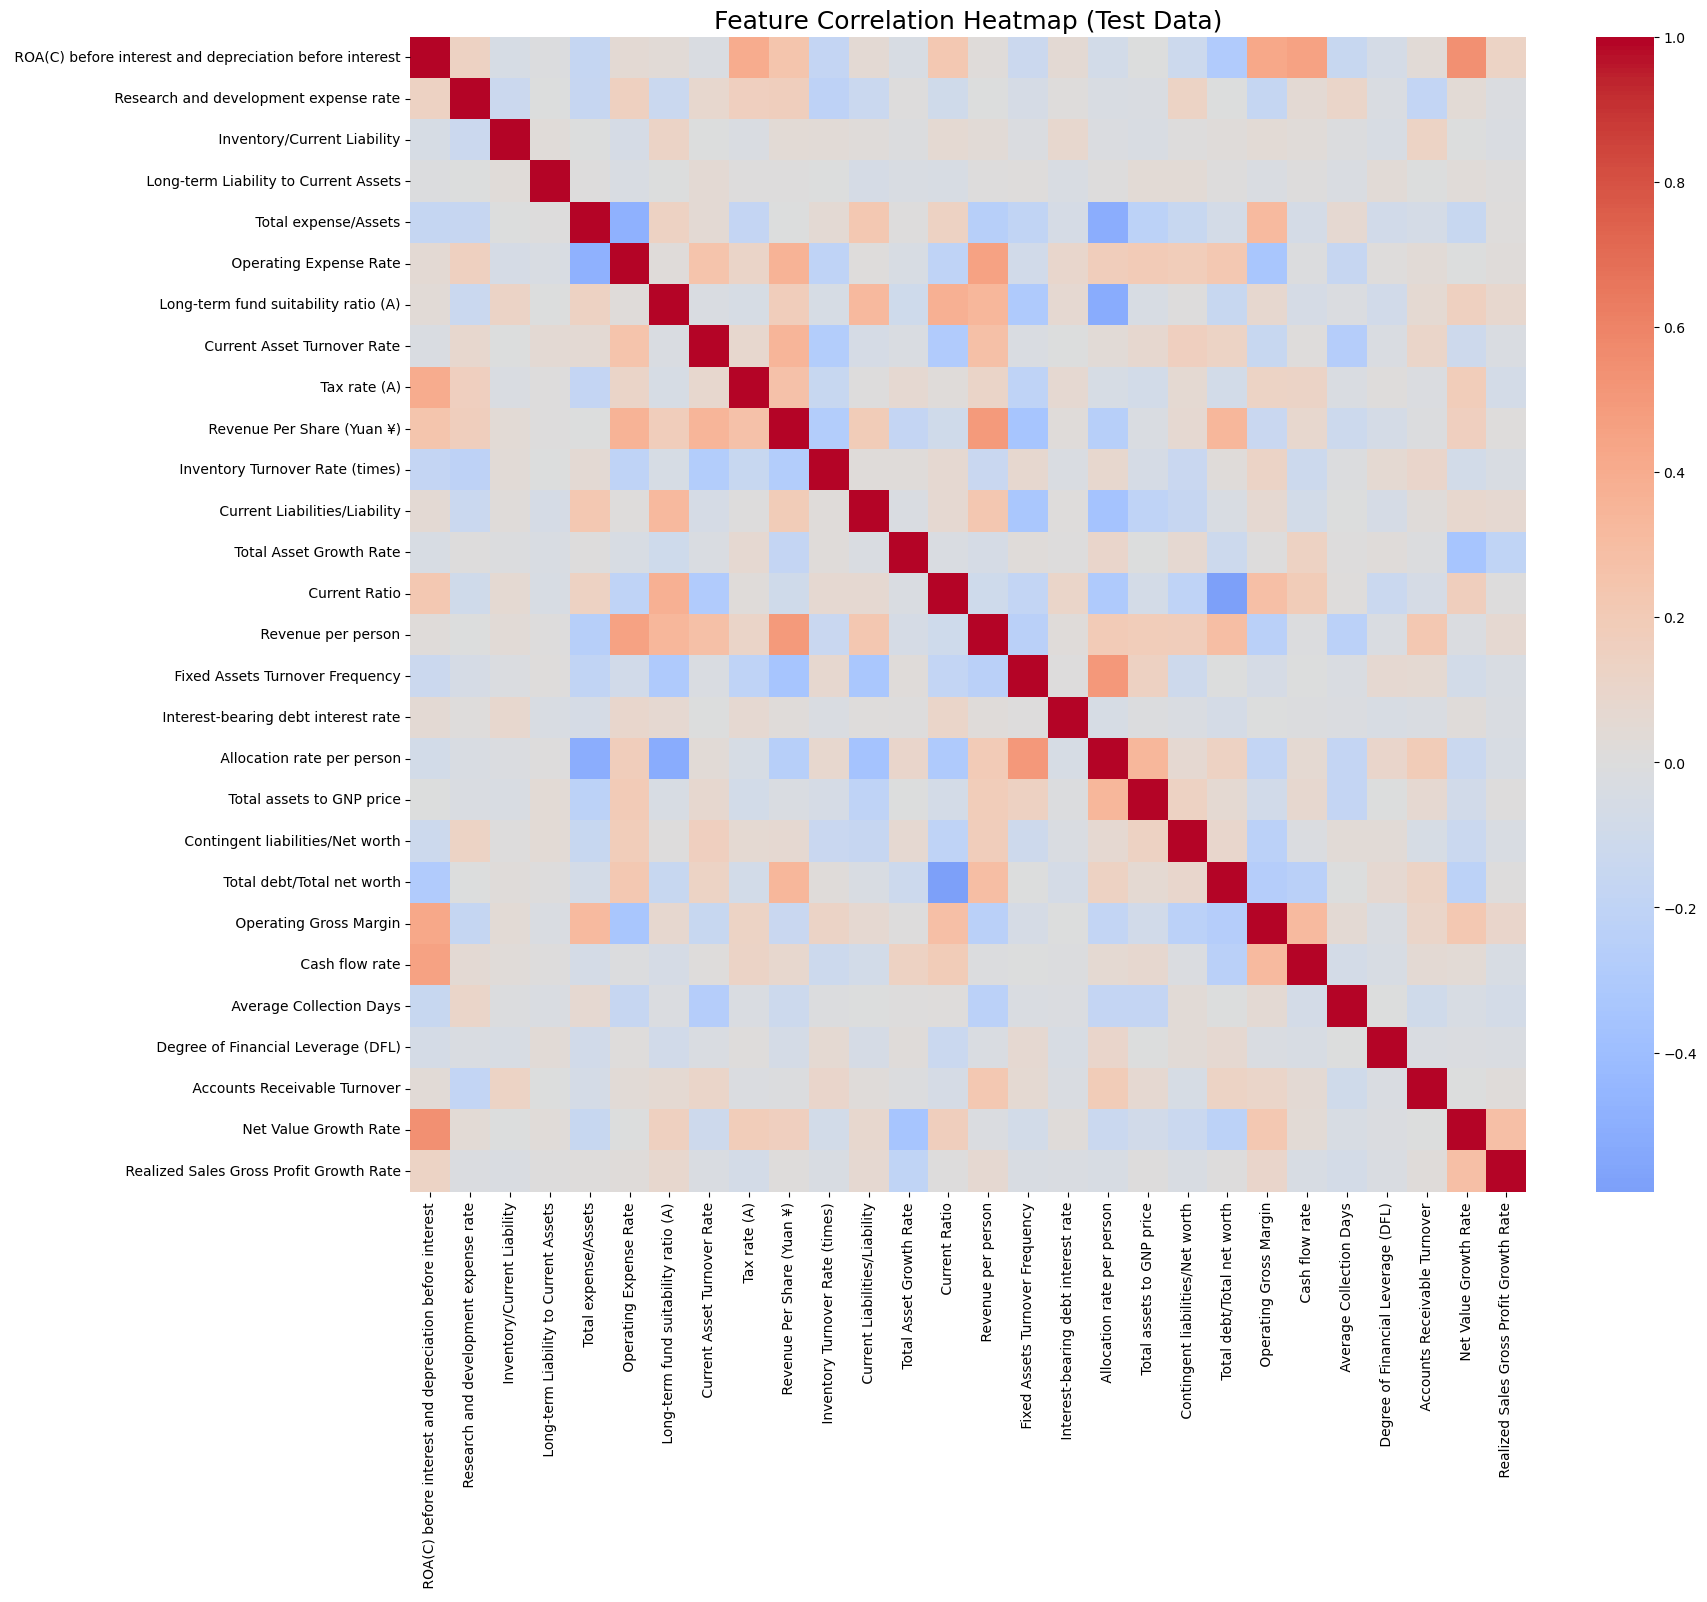

In [20]:
# Correlation Heatmap 
print("Generating correlation heatmap of test data...")
plt.figure(figsize=(18, 15))
sns.heatmap(X_test_final.corr(), cmap='coolwarm', center=0, annot=False)
plt.title('Feature Correlation Heatmap (Test Data)', fontsize=18)
plt.show()


Loading saved cluster classifier model...
Cluster classifier model loaded.

Predicting cluster IDs for test companies...
Cluster IDs predicted.

Visualizing cluster ID distribution...


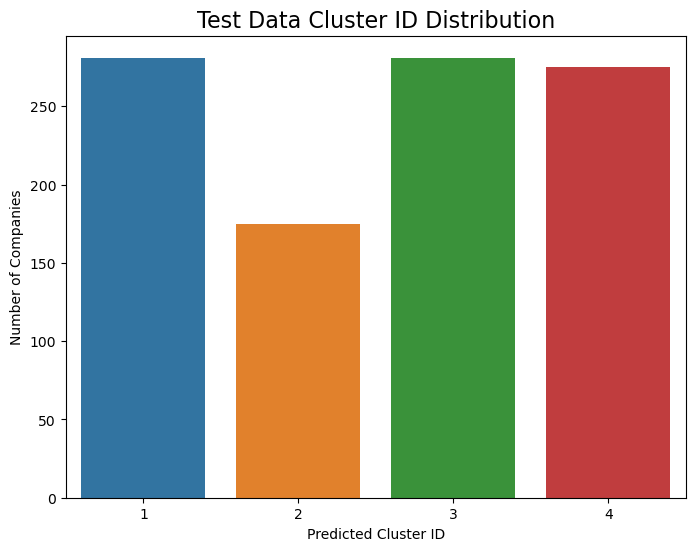

Visualizing clusters in 2D space...


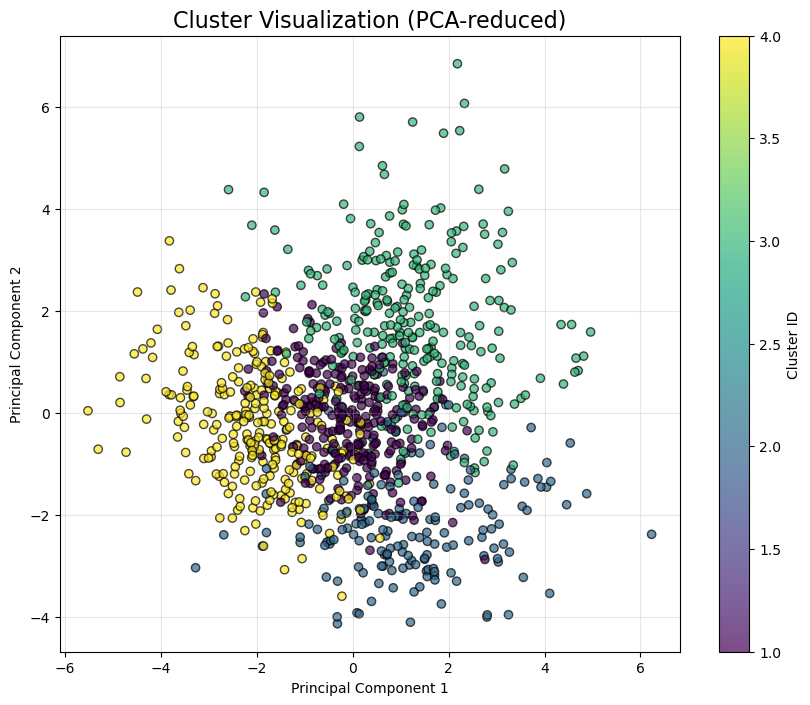


Cluster composition (Test Data):


,total
cluster,
1,281
2,175
3,281
4,275


In [22]:
# --- Load Cluster Classifier ---
print("Loading saved cluster classifier model...")
cluster_classifier = joblib.load('cluster_classifier_rf.joblib')
print("Cluster classifier model loaded.\n")

# -- Ensure train and test features are in same order ---
expected_features = cluster_classifier.feature_names_in_
X_test_final_ordered = X_test_final[expected_features]

# --- Predict Cluster IDs ---
print("Predicting cluster IDs for test companies...")
test_clusters = cluster_classifier.predict(X_test_final_ordered)
print("Cluster IDs predicted.\n")

# Create "Cluster" column with Cluster IDs for all test datapoints
X_test_final["Cluster"] = test_clusters

#add Index column back
X_test_final["Index"] = test_index

# --- Cluster ID Distribution ---
print("Visualizing cluster ID distribution...")
plt.figure(figsize=(8, 6))
sns.countplot(x=test_clusters)
plt.title('Test Data Cluster ID Distribution', fontsize=16)
plt.xlabel('Predicted Cluster ID')
plt.ylabel('Number of Companies')
plt.show()

# --- Scatter Plot Visualization ---
print("Visualizing clusters in 2D space...")
plt.figure(figsize=(10, 8))

# Reduce to 2 dimensions using PCA for visualization
pca = PCA(n_components=2)
X_test_2d = pca.fit_transform(X_test_final_ordered)

# Create scatter plot colored by cluster
scatter = plt.scatter(X_test_2d[:, 0], X_test_2d[:, 1], c=test_clusters, 
                     cmap='viridis', alpha=0.7, edgecolor='k')

plt.title('Cluster Visualization (PCA-reduced)', fontsize=16)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, label='Cluster ID')
plt.grid(True, alpha=0.3)
plt.show()

# --- Print Cluster Summary Table ---
cluster_df = pd.DataFrame({
    "cluster": test_clusters
})

# Summarize just the total number of companies per cluster
summary = (
    cluster_df
    .groupby("cluster")
    .size()                    
    .to_frame(name="total")     
    .sort_index()
)

# --- Display
print("\nCluster composition (Test Data):")
display(summary)

In [23]:
X_test_final.head()

,ROA(C) before interest and depreciation before interest,Research and development expense rate,Inventory/Current Liability,Long-term Liability to Current Assets,Total expense/Assets,Operating Expense Rate,Long-term fund suitability ratio (A),Current Asset Turnover Rate,Tax rate (A),Revenue Per Share (Yuan ¥),...,Total debt/Total net worth,Operating Gross Margin,Cash flow rate,Average Collection Days,Degree of Financial Leverage (DFL),Accounts Receivable Turnover,Net Value Growth Rate,Realized Sales Gross Profit Growth Rate,Cluster,Index
0,-1.459946,-1.125416,0.912864,-0.236364,1.662563,-0.703378,-0.176836,-0.466866,-1.047772,-0.716850,...,-0.941278,0.091600,-0.844495,0.419707,-0.104267,-0.227334,-0.724296,-0.095799,4,0
1,-0.165694,-1.125428,-0.296419,1.701984,-0.437938,-0.703425,-0.712934,2.140879,0.980754,-0.509507,...,1.079342,0.181454,0.753310,-0.811542,-0.022674,2.204948,-2.459264,-0.064827,2,1
2,-0.095537,1.049487,-0.230439,-0.243814,0.017907,-0.703425,0.057692,-0.466889,-1.047772,-0.911940,...,-0.861100,-0.170333,0.368231,-0.023698,-0.087786,-0.182709,-0.303738,-0.015508,4,2
3,1.231890,0.705075,-0.225400,0.015093,-0.450678,1.422080,1.018201,2.142527,0.607887,2.003014,...,-0.000242,-0.606041,0.252749,-0.285763,-0.086782,-0.124430,0.222919,-0.024956,3,3
4,-1.753887,-1.125428,-0.198821,-0.096034,1.340532,-0.703393,-0.722386,-0.466951,-1.047772,-0.420092,...,-0.015192,-0.633408,-0.442563,0.071119,-0.152320,-0.195731,-1.240521,-0.080510,1,4



Cluster 1 Bankruptcy Prediction Summary:


,count,percentage
Prediction,,
Healthy,269,99.63
Predicted Bankrupt,1,0.37


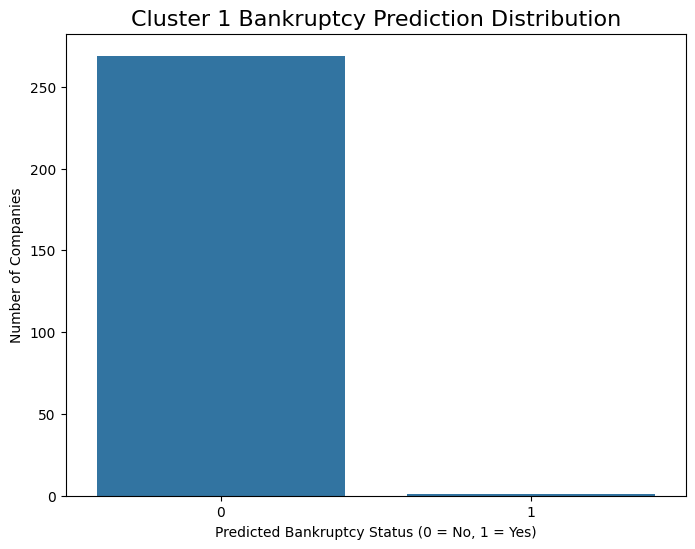

In [53]:
# CLUSTER 1 MODEL - SWATHI 

df_cl1 = X_test_final[X_test_final["Cluster"]==1]

# Save Indexes to attach back later
cl1_indexes = df_cl1["Index"]

# function to further process test data for cluster 1 model
def process_data_cl1(df):
    X_selected = df[[' Total expense/Assets', ' Revenue Per Share (Yuan ¥)', ' Revenue per person', ' Total debt/Total net worth']]
    return X_selected
        

X_selected1 = process_data_cl1(df_cl1)

# -- Load in model ------
model =joblib.load('cluster1_stacking_model.joblib')
# Make prediction on all datapoints in Cluster 1 df
cl1_predictions = []
for i, row in X_selected1.iterrows():
    company_features = row.values.reshape(1, -1)
    prediction = model.predict(company_features)[0]
    cl1_predictions.append(prediction)
    

# -- Append "Predictions" and "Index" column to X_selected df ----
X_selected1["Prediction"] = cl1_predictions
X_selected1["Index"] = cl1_indexes
X_selected1.head()


# --- Create Bankruptcy Prediction Summary ---
summary = (
    X_selected1["Prediction"]
    .value_counts()
    .rename(index={0: "Healthy", 1: "Predicted Bankrupt"})
    .to_frame(name="count")
)

# -- Calculate percentage ----
summary["percentage"] = (summary["count"] / summary["count"].sum() * 100).round(2)

# -- Display ---
print("\nCluster 1 Bankruptcy Prediction Summary:")
display(summary)

# -- Plot ----
plt.figure(figsize=(8, 6))
sns.countplot(x=cl1_predictions)
plt.title('Cluster 1 Bankruptcy Prediction Distribution', fontsize=16)
plt.xlabel('Predicted Bankruptcy Status (0 = No, 1 = Yes)')
plt.ylabel('Number of Companies')
plt.show()

In [54]:
X_selected1.head()


,Total expense/Assets,Revenue Per Share (Yuan ¥),Revenue per person,Total debt/Total net worth,Prediction,Index
3,-0.450678,2.003014,1.717115,-0.000242,0,3
5,0.155438,-1.252895,2.427579,0.503182,0,5
6,-0.957903,0.171527,-0.228101,0.019086,0,6
10,-1.069772,-0.230091,2.245138,-0.444654,0,10
14,-1.665019,0.340375,1.547663,0.795135,0,14



Cluster 2 Bankruptcy Prediction Summary:


,count,percentage
Predicted Bankrupt,120,68.57
Healthy,55,31.43


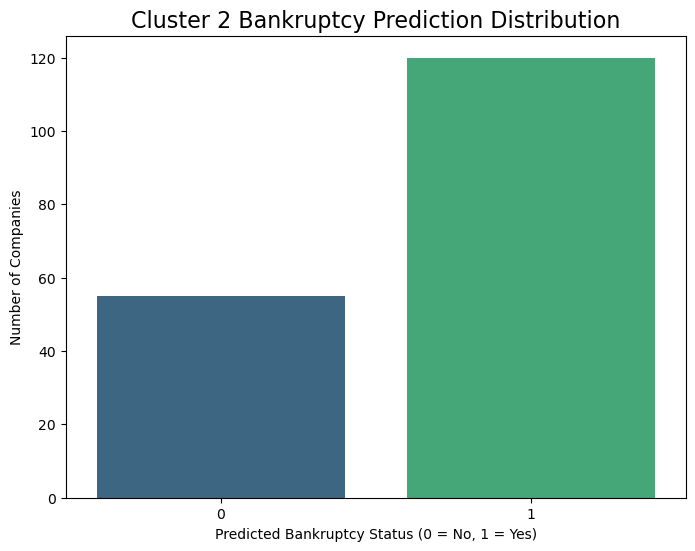

In [24]:
# CLUSTER 2 MODEL - SHREEL
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
import joblib
import matplotlib.pyplot as plt
import seaborn as sns


df_cl2 = X_test_final[X_test_final["Cluster"]==2]
cl2_indexes = df_cl2["Index"]

def safe_polynomial_transform(X, degree=10, poly_object=None, scaler=None):
   
    
    X_clean = X.replace([np.inf, -np.inf], np.nan).copy()
    

    X_clean.fillna(X_clean.mean(), inplace=True)
    
  
    for col in X_clean.columns:
        q1 = X_clean[col].quantile(0.01)
        q99 = X_clean[col].quantile(0.99)
        X_clean[col] = np.clip(X_clean[col], q1, q99)
    

    if scaler is None:
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_clean)
    else:
        X_scaled = scaler.transform(X_clean)
    

    if poly_object is None:
        poly = PolynomialFeatures(degree=degree, include_bias=False)
        X_poly = poly.fit_transform(X_scaled)
    else:
        X_poly = poly_object.transform(X_scaled)
 
    max_float32 = np.finfo(np.float32).max
    X_poly = np.clip(X_poly, -max_float32, max_float32)
    
    return X_poly, poly, scaler

# Load test data
X_test = df_cl2[[
    ' Fixed Assets Turnover Frequency',
    ' Revenue per person',
    ' Operating Expense Rate'
]].copy()


try:
    poly = joblib.load('poly_features.joblib')
    scaler = joblib.load('scaler.joblib')
except:
    poly, scaler = None, None


X_test_poly, poly, scaler = safe_polynomial_transform(
    X_test, 
    degree=10,
    poly_object=poly,
    scaler=scaler
)





model = joblib.load('cluster_2_shreel_stacked_model.joblib')  # Update filename
predictions = model.predict(X_test_poly)
probabilities = model.predict_proba(X_test_poly)[:, 1]  # Probability of class 1

X_test_poly_df = pd.DataFrame(X_test_poly)  # Convert back to DataFrame for alignment
X_test_poly_df["Prediction"] = predictions
X_test_poly_df["Index"] = cl2_indexes.values  # Reattach original indexes

# --- Create Bankruptcy Prediction Summary ---
summary = (
    X_test_poly_df["Prediction"]
    .value_counts()
    .rename(index={0: "Healthy", 1: "Predicted Bankrupt"})
    .to_frame(name="count")
)

# -- Calculate percentage ---
summary["percentage"] = (summary["count"] / summary["count"].sum() * 100).round(2)

# -- Display summary table ---
print("\nCluster 2 Bankruptcy Prediction Summary:")
display(summary)

# --- Plot ---
plt.figure(figsize=(8, 6))
sns.countplot(x=predictions, palette='viridis')
plt.title('Cluster 2 Bankruptcy Prediction Distribution', fontsize=16)
plt.xlabel('Predicted Bankruptcy Status (0 = No, 1 = Yes)')
plt.ylabel('Number of Companies')
plt.show()





Cluster 3 Bankruptcy Prediction Summary:


,count,percentage
Prediction,,
Healthy,315,99.68
Predicted Bankrupt,1,0.32


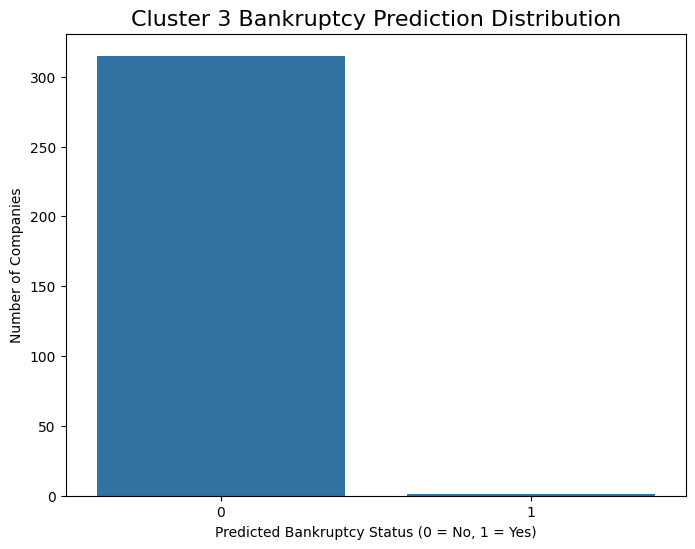

In [55]:
# CLUSTER 3 MODEL - Jack 

df_cl3 = X_test_final[X_test_final["Cluster"]==3]

# Save Indexes to attach back later
cl3_indexes = df_cl3["Index"]

# function to further process test data for cluster 3 model
def process_data_cl3(df):
    X_selected = df[[" Total expense/Assets", " Revenue Per Share (Yuan ¥)", 
                   " Current Liabilities/Liability", " Total debt/Total net worth", 
                   " Degree of Financial Leverage (DFL)"]]
    return X_selected
        

X_selected3 = process_data_cl3(df_cl3)

# -- Load in model ------
model = joblib.load('cluster3_stacking_model.joblib')
# Make prediction on all datapoints in Cluster 3 df
cl3_predictions = []
for i, row in X_selected3.iterrows():
    company_features = row.values.reshape(1, -1)
    prediction = model.predict(company_features)[0]
    cl3_predictions.append(prediction)
    

# -- Append "Predictions" and "Index" column to X_selected3 df ----
X_selected3["Prediction"] = cl3_predictions
X_selected3["Index"] = cl3_indexes
X_selected3.head()


# --- Create Bankruptcy Prediction Summary ---
summary = (
    X_selected3["Prediction"]
    .value_counts()
    .rename(index={0: "Healthy", 1: "Predicted Bankrupt"})
    .to_frame(name="count")
)

# -- Calculate percentage ----
summary["percentage"] = (summary["count"] / summary["count"].sum() * 100).round(2)

# -- Display ---
print("\nCluster 3 Bankruptcy Prediction Summary:")
display(summary)

# -- Plot ----
plt.figure(figsize=(8, 6))
sns.countplot(x=cl3_predictions)
plt.title('Cluster 3 Bankruptcy Prediction Distribution', fontsize=16)
plt.xlabel('Predicted Bankruptcy Status (0 = No, 1 = Yes)')
plt.ylabel('Number of Companies')
plt.show()

In [37]:
# CLUSTER 4 MODEL - KHUSHI
# models = {
#     4: joblib.load('khushi_cluster4_stacking_model.joblib')
# }
# print("model loaded successfully.\n")

# # --- Predict Bankruptcy Status ---
# print("Predicting bankruptcy status for each company...")
# predictions = []

# for i, row in X_test_final.iterrows():
#     company_features = row.values.reshape(1, -1)
#     cluster_id = int(test_clusters[i])  # No +1 shifting needed
    
    
#     if cluster_id == 4:
#         model = models[cluster_id]
#         prediction = model.predict(company_features)[0]
    
#     else:
#         prediction = 0  # If no stacking model yet, predict 0 (Not Bankrupt)

#     predictions.append(prediction)

# print("Bankruptcy prediction completed.\n")


In [63]:
# MERGE ALL CLUSTER PREDICTIONS WITH ORIGINAL TEST DATA

# add back test indices to X_test_final
X_test_final["Index"] = test_index
#X_test_final.head()

all_predictions = pd.concat([
    X_selected1[["Index", "Prediction"]],
    X_test_poly_df[["Index", "Prediction"]],
    X_selected3[["Index", "Prediction"]],
    # df_cl4[["Index", "Prediction"]]
])

X_test_final_with_predictions = X_test_final.merge(all_predictions, on="Index", how="left")

table2 = X_test_final_with_predictions[["Index","Prediction"]]
table2.rename(columns={"Prediction": "Bankrupt?"}, inplace=True)
table2["Bankrupt?"] = table2["Bankrupt?"].astype(int) # make int

In [64]:
table2.head()

,Index,Bankrupt?
0,0,NaN
1,1,NaN
2,2,NaN
3,3,0.0
4,4,0.0


In [65]:
# write table 2 to CSV

table2.to_csv("Group4_Generalization.csv")

In [ ]:
print("Visualizing bankruptcy prediction distribution...")
plt.figure(figsize=(8, 6))
sns.countplot(x=predictions)
plt.title('Bankruptcy Prediction Distribution', fontsize=16)
plt.xlabel('Predicted Bankruptcy Status (0 = No, 1 = Yes)')
plt.ylabel('Number of Companies')
plt.show()


Visualizing bankruptcy prediction distribution...


NameError: name 'predictions' is not defined

<Figure size 800x600 with 0 Axes>

In [33]:
print("Creating final submission file...")
submission = pd.DataFrame({
    'Index': test_index,
    'Bankrupt?': predictions
})
submission.to_csv('submission.csv', index=False)
print("Submission file 'submission.csv' created successfully!\n")


Creating final submission file...


NameError: name 'predictions' is not defined